## This is the final script for laser-chopping mode spectrum 

This log is part of the data_analysis for 1st POLARIS XFEL beamtime at Desy, FLASH (Oct.2018)

(1) The optical laser will come in 5 Hz and xFEL comes in 10 Hz.

(2) we have two laser signals in HDF5 file, and in this script we will use the diode signal at the instrument side.

(3) !!!! we do a contineous slow delay scan !!!! and the delay scan rate is constant.

----------- 
 Created by  Hsin-Yi Wang (wang.hy@fysik.su.se), Date: 06-Oct-2018
 
- Note: This script shuld be operated under Python 3 environment 

### Import modules and useful function

In [79]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import h5py
import sys
from os import walk
import os.path

sys.path.insert(0, '../src/')
import fit_data_tools
from fit_data_tools import *
import save_2_IGOR_file_05 as sif

### Import parameters 

In [85]:
####################################################
# Define the ratio between pixel and energy scale  #
####################################################
Ep = 100 # Passing energy
Pixels2V = 0.1654*Ep/1000 #  = how much V per pixel
#Pixels2V = 0.1695*EP/1000 # obtained from our electron gun testing

#######################
# Spectrum parameters #
#######################
Set_Vcenter = 305 # The setting voltage cneter

Mode = 'Fix' # Fix or Sweep

if Mode == 'Sweep':
    Escan_Vi = 1 
    Escan_Vf = 2
if Mode =='Fix':
    Escan_Vi = Set_Vcenter -240*Pixels2V 
    Escan_Vf = Set_Vcenter +240*Pixels2V 

Time_Zero =  float(-160.474) # unit: fs, This value changes if you read out the delay stage from different channels
files=[5] # File name, ex: files = [1] for XPS001. By now the number should be < 999 
Spectrum_name = ["C1s"] # the name for this spectrum
#save_2_igor = 1 # 1 = 
Polar = ["V"] # H for Horizontal, V for vertical

######################
# Creating threshold #
######################
thr_camera = 30 # smallest blob number per pixel
thr_Laser = 100
##########################################
# Binning data into perticlur time delay #
##########################################
Delay = np.array([-1,-0.5,0,0.5,1,1.5,2]) # ps

### Start to do data analysis and polt out the filgure

['FLASH1_USER2_stream_2_run25152_file7_20181009T014342.1.h5'
 'FLASH1_USER2_stream_2_run25152_file16_20181009T020703.1.h5'
 'FLASH1_USER2_stream_2_run25152_file15_20181009T020428.1.h5'
 'FLASH1_USER2_stream_2_run25152_file8_20181009T014617.1.h5'
 'FLASH1_USER2_stream_2_run25152_file4_20181009T013554.1.h5'
 'FLASH1_USER2_stream_2_run25152_file19_20181009T021451.1.h5'
 'FLASH1_USER2_stream_2_run25152_file2_20181009T013042.1.h5'
 'FLASH1_USER2_stream_2_run25152_file11_20181009T015404.1.h5'
 'FLASH1_USER2_stream_2_run25152_file5_20181009T013830.1.h5'
 'FLASH1_USER2_stream_2_run25152_file12_20181009T015640.1.h5'
 'FLASH1_USER2_stream_2_run25152_file22_20181009T022238.1.h5'
 'FLASH1_USER2_stream_2_run25152_file17_20181009T020939.1.h5'
 'FLASH1_USER2_stream_2_run25152_file25_20181009T023025.1.h5'
 'FLASH1_USER2_stream_2_run25152_file21_20181009T022002.1.h5'
 'FLASH1_USER2_stream_2_run25152_file13_20181009T015916.1.h5'
 'FLASH1_USER2_stream_2_run25152_file18_20181009T021215.1.h5'
 'FLASH1_USER

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less


[ 1.23913477  1.23898218  1.23915002 ..., -1.00840857 -1.00853064
 -1.00851538]
[ 1.2390127   1.23915002  1.23892114 ..., -1.00859167 -1.00843909
 -1.00853064]
Check the pixels2V range by two differnt methods for XPS005
AssReal_Escan_Vf = 319.721
Check_AssReal_Escan_Vf = 319.737


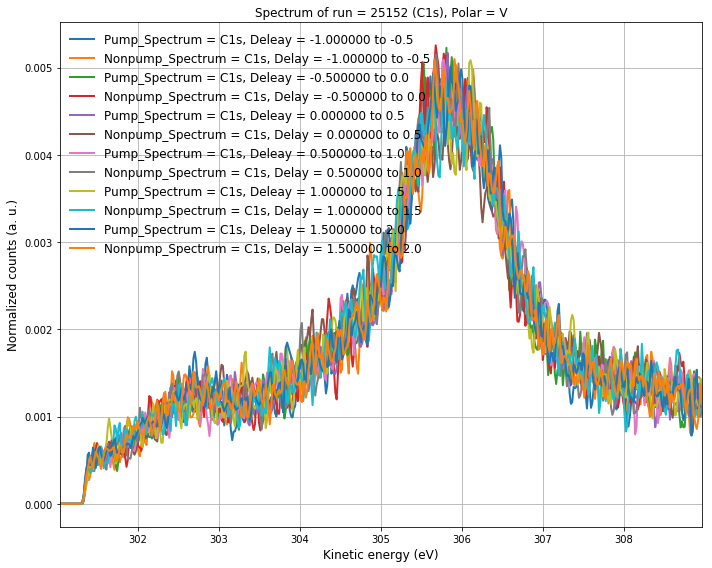

In [86]:
######################
# Load the data file #
######################
i = 0
while i < len(files):
    data_path = '../DATA/'+'XPS%03d/' %files[i]
    if not os.path.exists(data_path) :
        raise NameError('Check data_path! It does not exist!')
    data_names = discover_datas(data_path)
    print (data_names)
    
    fileName = data_names[0]
    runNum = fileName[fileName.find('run',0)+3:fileName.find('_file',0)-len(fileName)]
    
    #############################################
    # Creating empty matirx for collecting data #
    #############################################
    Total_profile = []
    Extend_total_profile = []
    Total_V = []
    Laser = []
    Total_delay = []
    
    P_filter = [] # Pumped 
    NP_filter = [] # NonPumed

    P_Total_profile = []
    P_Total_V = []
    P_Extend_total_profile = []
    P_Total_delay = []
    
    NP_Total_profile = []
    NP_Total_V = []
    NP_Extend_total_profile = []
    NP_Total_delay = []

    ################
    # Data process #
    ################
    for j in range(len(data_names)):
        h5file = h5py.File(data_path+data_names[j], 'r')
        Image = h5file['/FL1/Experiment/Camera/PG/Basler FW 1/image/'].value
        #Ind_profile = h5file['/FL1/Experiment/Camera/PG/Basler FW 1/ROI.X/'].value #The summed individule image along Y direction 
        Voltage_num = h5file['/FL1/Experiment/PG/SIS8300 100MHz ADC/CH6/TD/'].value
        Laser_reading = h5file['/FL1/Experiment/Pump probe laser/ADC/PP.3'].value #diodle at the instrument side
        #Laser_reading = h5file['/FL1/Experiment/PG/SIS8300 100MHz ADC/CH9/pulse energy/TD'].value # diodle at the upstream side
        #Delay_stage0 = h5file['/FL1/Experiment/Pump probe laser/laser delay'].value # Delay_stage0 and Delay_stage are from differnt channels. Delay_stage is more sensitive. 
        Delay_stage = h5file['/FL1/Experiment/Pump probe laser/delay line IK220.0/ENC'].value # unit: ps
        
        # Image
        Image[Image<thr_camera] = 0
        for m in np.arange((Image.shape[0])):
            Ind_profile = np.sum(Image[m,:,:],axis = 1)
            Total_profile.append(Ind_profile)
        # Voltage
        Ind_voltage_num = np.average(Voltage_num, axis = 1)
        Ind_voltage_num = Ind_voltage_num*650/(2**16)
        Total_V.extend(Ind_voltage_num)
        # Laser 
        Laser_reading[Laser_reading<0] = 0
        Laser_reading_Ind = np.sum(Laser_reading, axis = 1)
        Laser.extend(Laser_reading_Ind)  
        # Delay
        Total_delay.extend(Delay_stage[:,1])

    Total_profile = np.array(Total_profile)
    Total_V = np.array(Total_V)
    Total_V = np.nan_to_num(Total_V) # Setting all nan:s to zero
    Laser = np.array(Laser)
    Laser = np.nan_to_num(Laser) # Setting all nan:s to zero
    Total_delay = np.array(Total_delay)
    Total_delay = np.nan_to_num(Total_delay) # Setting all nan:s to zero

    if Mode =='Fix':
        Off_V = np.average(Total_V) - Set_Vcenter
        Total_V = Total_V - float(Off_V)
    
    Frame_Escan_Vi = Escan_Vi-320*float(Pixels2V)
    Frame_Escan_Vf = Escan_Vf+320*float(Pixels2V)
    
    P_filter = np.all([Laser > thr_Laser, Total_V != 0, Total_V >= Frame_Escan_Vi, Total_V <= Frame_Escan_Vf, Total_delay!=0], axis=0)
    NP_filter = np.all([Laser < thr_Laser, Total_V != 0, Total_V >= Frame_Escan_Vi, Total_V <= Frame_Escan_Vf, Total_delay!=0], axis=0)
    
    P_Total_profile = np.array(Total_profile[P_filter,:])
    P_Total_V = np.array(Total_V[P_filter])
    P_Total_delay = np.array(Total_delay[P_filter])
    P_Total_delay = (P_Total_delay - Time_Zero)*-1 # negative means we go postive delay
    print(P_Total_delay) 
    NP_Total_profile = np.array(Total_profile[NP_filter,:])
    NP_Total_V = np.array(Total_V[NP_filter])
    NP_Total_delay = np.array(Total_delay[NP_filter])
    NP_Total_delay = (NP_Total_delay - Time_Zero)*-1 # negative means we go postive delay
    print(NP_Total_delay)
    
    #############################################################
    # Plot out the pump/Npnpump Spectrum 2D map wothout binning #
    #############################################################
    """
    plt.figure(figsize=[12,6])   
    ax = plt.subplot(1,2,1)
    plt.imshow(P_Total_profile,vmin=0,vmax=P_Total_profile.max(), origin='lower', interpolation='bicubic',cmap='hot',alpha = 0.9)
    plt.xlabel('pixels',size=12)
    plt.ylabel('shots',size=12)
    plt.title('Pump_Spectrum 2D map')
    plt.xlim(0,640)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.1)
    plt.colorbar(cax=cax)
    ax.set_aspect(aspect=0.01)
    plt.show()
    
    plt.figure(figsize=[12,6])   
    ax = plt.subplot(1,2,2)
    plt.imshow(NP_Total_profile,vmin=0,vmax=NP_Total_profile.max(), origin='lower', interpolation='bicubic',cmap='hot',alpha = 0.9)
    plt.xlabel('pixels',size=12)
    plt.ylabel('shots',size=12)
    plt.title('Nonpump_Spectrum 2D map')
    plt.xlim(0,640)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.1)
    plt.colorbar(cax=cax)
    ax.set_aspect(aspect=0.01)
    plt.show()
    """
    ############################################
    # Convert all energy scale to pixels scale #
    ############################################
    AssFull_pixels_range = np.ceil((Escan_Vf-Escan_Vi)/float(Pixels2V))+ (640+10)*2
    AssFull_pixels_range = int(AssFull_pixels_range)
    AssReal_Escan_Vi = Escan_Vi-(640+10)*float(Pixels2V)
    AssReal_Escan_Vf = Escan_Vf+(640+10)*float(Pixels2V)
    # 10 more pixels are used to make sure all the spectrum is in our pixels_range
    
    Check_AssReal_Escan_Vf = AssReal_Escan_Vi+(AssFull_pixels_range)*float(Pixels2V)
    print ('Check the pixels2V range by two differnt methods for XPS%03d' %files[i])
    print ('AssReal_Escan_Vf = %0.3f'%AssReal_Escan_Vf)
    print ('Check_AssReal_Escan_Vf = %0.3f'%Check_AssReal_Escan_Vf)

    for p in np.arange(P_Total_profile.shape[0]):
        P_Profile_center = np.ceil((float(P_Total_V[p])-AssReal_Escan_Vi)/float(Pixels2V))
        P_Profile_center  = int(P_Profile_center)
        P_Extend_profile = np.concatenate([np.zeros(P_Profile_center-320), P_Total_profile[p,:], np.zeros(AssFull_pixels_range-P_Profile_center-320)])
        P_Extend_total_profile.append(P_Extend_profile)
    P_Extend_total_profile = np.array(P_Extend_total_profile)
    
    for n in np.arange(NP_Total_profile.shape[0]):
        NP_Profile_center = np.ceil((float(NP_Total_V[n])-AssReal_Escan_Vi)/float(Pixels2V))
        NP_Profile_center  = int(NP_Profile_center)
        NP_Extend_profile = np.concatenate([np.zeros(NP_Profile_center-320), NP_Total_profile[n,:], np.zeros(AssFull_pixels_range-NP_Profile_center-320)])
        NP_Extend_total_profile.append(NP_Extend_profile)
    NP_Extend_total_profile = np.array(NP_Extend_total_profile)
    
    ######################################################
    # Start to bin the data into desired dealy intervals #
    ######################################################
    Total_P_Spectrum = np.zeros(P_Extend_total_profile.shape[1])
    Total_NP_Spectrum = np.zeros(NP_Extend_total_profile.shape[1])
    k = 0
    plt.figure(figsize=[10,8])
    while k <(len(Delay)-1):
        P_mask = np.all([P_Total_delay>= float(Delay[k]), P_Total_delay< float(Delay[k+1])],axis=0)
        Selected_P_Extend_total_profile = P_Extend_total_profile[P_mask,:]
        Selected_P_Spectrum = np.sum(Selected_P_Extend_total_profile,axis = 0)
        Selected_P_Spectrum /= np.sum(Selected_P_Spectrum) #we normaized it by overall spectrum intensity
        Total_P_Spectrum = np.vstack((Total_P_Spectrum, Selected_P_Spectrum))
         
        NP_mask = np.all([NP_Total_delay>= float(Delay[k]), NP_Total_delay< float(Delay[k+1])],axis=0)
        Selected_NP_Extend_total_profile = NP_Extend_total_profile[NP_mask,:]
        Selected_NP_Spectrum = np.sum(Selected_NP_Extend_total_profile,axis = 0)
        Selected_NP_Spectrum /= np.sum(Selected_NP_Spectrum) #we normaized it by o verall spectrum intensity
        Total_NP_Spectrum = np.vstack((Total_NP_Spectrum, Selected_NP_Spectrum))
        
        ######################################################################
        # Plot out the pump and nonpump spectrum in the desired energy range #
        ######################################################################
        E_scale = np.arange(AssFull_pixels_range)*float(Pixels2V)+AssReal_Escan_Vi 
        Frame_mask = np.all([E_scale >= Escan_Vi, E_scale <= Escan_Vf], axis=0)
        Selected_P_Spectrum = Selected_P_Spectrum[Frame_mask]
        Selected_NP_Spectrum = Selected_NP_Spectrum[Frame_mask]
        E_scale = E_scale[Frame_mask]
        plt.plot(E_scale,Selected_P_Spectrum,ls = '-',linewidth ='2', label = 'Pump_Spectrum = %s, Deleay = %f to %.1f' %(Spectrum_name[i], Delay[k], Delay[k+1]))
        plt.plot(E_scale,Selected_NP_Spectrum,ls = '-',linewidth ='2', label = 'Nonpump_Spectrum = %s, Delay = %f to %.1f' %(Spectrum_name[i], Delay[k], Delay[k+1]))
        plt.xlabel('Kinetic energy (eV)',size=12)
        plt.ylabel('Normalized counts (a. u.)',size=12) 
        plt.grid(True)
        plt.xlim(Escan_Vi,Escan_Vf)
        plt.tight_layout()
        plt.legend(frameon=False,loc='best', prop={'size': 12})
        plt.title('Spectrum of run = %s (%s), Polar = %s' %(runNum, Spectrum_name[i], Polar[i]), size=12)
        k = k + 1
    plt.show()
                 
    #####################
    # Save the data.txt #
    #####################
    Total_P_Spectrum = np.delete(Total_P_Spectrum, 0, axis=0)
    Total_NP_Spectrum = np.delete(Total_NP_Spectrum, 0, axis=0)
    Total_P_Spectrum = Total_P_Spectrum [:,Frame_mask]
    Total_NP_Spectrum = Total_NP_Spectrum [:,Frame_mask]

    save_path = '../DATA/export/' 
    if not os.path.exists(os.path.join(save_path)):
        os.makedirs(os.path.join(save_path))
        
    P_completeName = os.path.join(save_path, "P_Spectrum_XPS%03d_%s" %(files[i],Polar[i]) + ".txt")         
    with open (P_completeName, "w") as out_file:
        for l in range(len(E_scale)):
            out_string = ""
            out_string += str(E_scale[l])
            for d in range(len(Delay)-1):
                out_string += ","+str(Total_P_Spectrum[d,l])
            out_string += "\n"
            out_file.write(out_string)
    
    NP_completeName = os.path.join(save_path, "NP_Spectrum_XPS%03d_%s" %(files[i],Polar[i]) + ".txt")         
    with open (NP_completeName, "w") as out_file:
        for l in range(len(E_scale)):
            out_string = ""
            out_string += str(E_scale[l])
            for d in range(len(Delay)-1):
                out_string += ","+str(Total_NP_Spectrum[d,l])
            out_string += "\n"
            out_file.write(out_string)
            
    """
    waveName = "P_Spectrum_XPS%03d" %files[i]
    run = files[i]
    runType = 'XPS'
    if save_2_igor == 1: # Saving the data to IGOR text
        sif.save_2to1_data(save_path,P_Spectrum,E_scale,waveName,run,runType)
    
    waveName = "NP_Spectrum_XPS%03d" %files[i]
    run = files[i]
    runType = 'XPS'
    if save_2_igor == 1: # Saving the data to IGOR text
        sif.save_2to1_data(save_path,NP_Spectrum,E_scale,waveName,run,runType)
    """
    i = i+1

### Plot out the spectrum  (.txt data) from saved folder

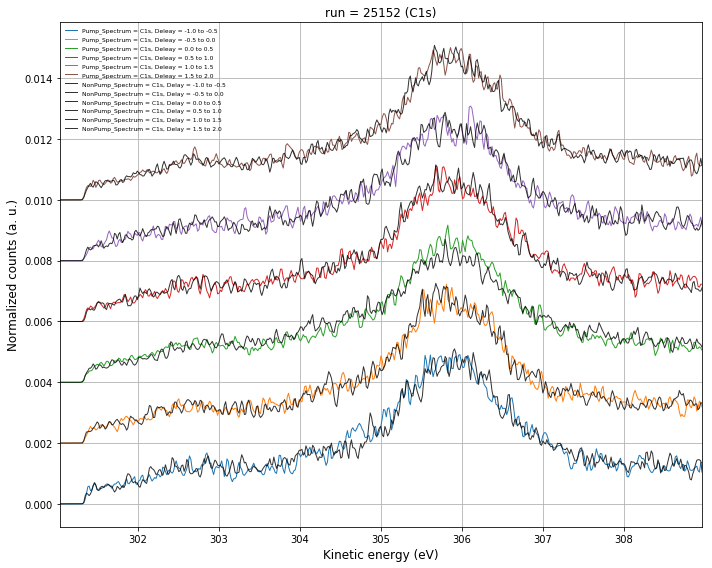

In [87]:
txt_files = [5]
Polar = ["V"]
P_data=np.loadtxt("../DATA/export/P_Spectrum_XPS%03d_%s.txt" %(txt_files[0], Polar[0]), delimiter =',')
NP_data=np.loadtxt("../DATA/export/NP_Spectrum_XPS%03d_%s.txt" %(txt_files[0], Polar[0]), delimiter =',')
P_data = np.array(P_data)
NP_data = np.array(NP_data)

sp0 = 0
plt.figure(figsize=[10,8])
while sp0 < P_data.shape[1]-1:
    P_X=(P_data[:,0])
    P_Y=(P_data[:,sp0+1])+sp0*0.002
    plt.plot(P_X,P_Y,"-",linewidth ='1', label = 'Pump_Spectrum = %s, Deleay = %.1f to %.1f' %(Spectrum_name[0], Delay[sp0], Delay[sp0+1]))
    plt.xlabel('Kinetic energy (eV)',size=12)
    plt.ylabel('Normalized counts (a. u.)',size=12)
    plt.title('run = %s (%s)' %(runNum,Spectrum_name[0]),size=12)
    plt.grid()
    plt.xlim(Escan_Vi,Escan_Vf)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(frameon=False,loc='best', prop={'size': 6})
    plt.tick_params(axis='both', which='major', labelsize=10)
    sp0 = sp0 + 1
    
sp1 = 0

while sp1 < NP_data.shape[1]-1:
    NP_X=(NP_data[:,0])
    NP_Y=(NP_data[:,sp1+1])+sp1*0.002
    plt.plot(NP_X,NP_Y,'-',linewidth ='1', color = 'black', alpha = 0.8, label = 'NonPump_Spectrum = %s, Delay = %.1f to %.1f' %(Spectrum_name[0], Delay[sp1], Delay[sp1+1]))
    plt.xlabel('Kinetic energy (eV)', size=12)
    plt.ylabel('Normalized counts (a. u.)', size=12)
    plt.title('run = %s (%s)' %(runNum,Spectrum_name[0]),size=12)
    plt.grid()
    plt.xlim(Escan_Vi,Escan_Vf)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(frameon=False,loc='best', prop={'size': 6})
    plt.tick_params(axis='both', which='major', labelsize=10)               
    sp1 = sp1 + 1
    plt.savefig('/Users/Hsin-YiWang/Desktop/run%s.jpg'%runNum, dpi=300)
plt.show()
